<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/aml_2324_w5_ensembling_avgvot_stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensembling (Heterogenous) Models: Averaging/Voting and Stacking

* 6G7V0017 Advanced Machine Learning, S2 W5
* Luciano Gerber

## Outline

* Practical presentation of ensembling models with averaging/voting and stracking.

* Models here are normally heterogenous (i.e., of different types such trees and kNN).

* Empirically, shown to perform better than individual models, given some constraints:
    - Models should have comparable performance (e.g., ensembling a poor model with a few good ones is likely to bring the one ensemble down).
    - Models likely to behave different for different observations/regions of the data.

* Think of collective intelligence, of asking a number of experts their option on a hard problem.

* We have already covered **bagging** (bootstrap aggregation) and their typical implementation as an off-the-shelf algorithm in the shape of **Random Forests** (averaging/voting with sampling of features and observations).

* In a nutshelf:
    - **Averaging/Voting**: You that those $n$ models (that score similarly but behave differently); take their predictions for an observation and **average them** into a single prediction.
    
        + For classification, it can be **hard** or **soft**. Hard just means to take the majority class as the output (hard predictions); with soft one takes the mean probability (soft predictions).

        + For regression, typically, the mean of the prediction.

## Import Packages and Set Up Environment

In [ ]:
# latest version of scikit-learn: might need a kernel resta§rt
!pip install --upgrade scikit-learn==1.4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 47.6 MB/s eta 0:00:00


In [ ]:
import sklearn
# this makes is easier for getting dataframes by default as input/output of
# sklearn pipelines
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

In [ ]:
# We will try different implementations of tree ensembles
# We are familiar with Random Forests; today, we'll use Boosted Trees as
# black boxes, but will revisit the intution behind them later in the unit

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# SHAP is not normally part of a standard Python distribution
# I am installing it here by asking the underlying operating system to
# `pip install` the package (`-q` for a quiet output)
!pip install -q shap
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 11.5 MB/s eta 0:00:00


## Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/gerberl/6G7V0017-2324/main/datasets/winequality-white.csv'
wine = pd.read_csv(url, sep=';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
y = wine['quality']
X = wine.drop('quality', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=0
)

## Reusable Pre-Processing and Model Fitting Pipelines

In [ ]:
def create_pp_ppln(X, linear_model=False):
    """creates a default preprocessing pipeline for numeric and categorical data
    using simple imputers, scalers, and encoders. It relies on latest versions
    of sklearn so as to produce pandas outputs.

    X: the dataset with the features (needed for feature names)

    returns the Pipeline object
    """

    numeric_features = X.select_dtypes(exclude='object').columns.tolist()
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean"))
        ]
    )
    # if we are dealing with a linear model I'll add scaling/polynomial features
    if linear_model:
        numeric_transformer.steps.extend([
            ("scaler", StandardScaler()),
            ('poly', PolynomialFeatures(include_bias=False))
        ])

    categorical_features = X.select_dtypes(include='object').columns.tolist()
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

    return preprocessor

In [ ]:
def create_regr_ppln(est, X, linear_model=False):
    """ """
    regr_pipe = Pipeline(
        steps=[
            ("pp", create_pp_ppln(X, linear_model)),
            ("regr", est)
        ]
    )

    return regr_pipe

## Model Fitting

In [ ]:
gbr  = create_regr_ppln(GradientBoostingRegressor(max_depth=3), X_train)
rfr  = create_regr_ppln(RandomForestRegressor(max_depth=8), X_train)
lr   = create_regr_ppln(LinearRegression(), X_train, linear_model=True)
my_models = [ gbr, rfr, lr ]

In [ ]:
model_results_list = []
for my_model in my_models:
    eval_results = cross_validate(
        my_model, X, y, cv=5,
        scoring='neg_mean_absolute_error',
        return_train_score=True
    )
    model_results_list.append(
        (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
         -eval_results['train_score'].mean(), eval_results['train_score'].std())
    )

In [ ]:
model_results = pd.DataFrame(
    model_results_list,
    columns=['test_mae_mean', 'test_mae_std', 'train_mae_mean', 'train_mae_std'],
    index=['gbr', 'rfr', 'lr']
)

In [ ]:
model_results

,test_mae_mean,test_mae_std,train_mae_mean,train_mae_std
gbr,0.576370,0.033386,0.490156,0.010519
rfr,0.578075,0.033701,0.442758,0.011227
lr,0.582137,0.033335,0.544973,0.008144


In [ ]:
for est in my_models:
    est.fit(X_train, y_train)

In [ ]:
ensemble = VotingRegressor(
    [
        ("gb", gbr),
        ("rf", rfr),
        ('lr', lr)
    ]
)
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('gb',
                             Pipeline(steps=[('pp',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               ['fixed '
                                                                                'acidity',
                                                                                'volatile '
                                                                                'acidity',
                                                                                'citric '
                                                                                'acid',
                                                                                'residual '
                                                                                'sugar',
                                                                                'chlorides',
                                                                                'free '
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                'total '
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                'density',
                                                                                'pH',
                                                                                'sulphates',
                                                                                'alcohol']),
                                                                              ('cat',
                                                                               Pipelin...
                                                                                'residual '
                                                                                'sugar',
                                                                                'chlorides',
                                                                                'free '
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                'total '
                                                                                'sulfur '
                                                                                'dioxide',
                                                                                'density',
                                                                                'pH',
                                                                                'sulphates',
                                                                                'alcohol']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
            

In [ ]:
eval_results = cross_validate(
    ensemble, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
ensemble_result = (
    -eval_results['test_score'].mean(), eval_results['test_score'].std(),
    -eval_results['train_score'].mean(), eval_results['train_score'].std()
)

In [ ]:
model_results.loc['ensemble'] = ensemble_result

In [ ]:
model_results

,test_mae_mean,test_mae_std,train_mae_mean,train_mae_std
gbr,0.576370,0.033386,0.490156,0.010519
rfr,0.578075,0.033701,0.442758,0.011227
lr,0.582137,0.033335,0.544973,0.008144
ensemble,0.565922,0.033209,0.482988,0.009796


## Inspection of Ensemble Output

In [ ]:
# quickly adapted from the sklearn documentation
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html
xt = X.head(20)
yt = y.head(20)
pred_gbr = gbr.predict(xt)
pred_rfr = rfr.predict(xt)
pred_lr = lr.predict(xt)
pred_ens = ensemble.predict(xt)

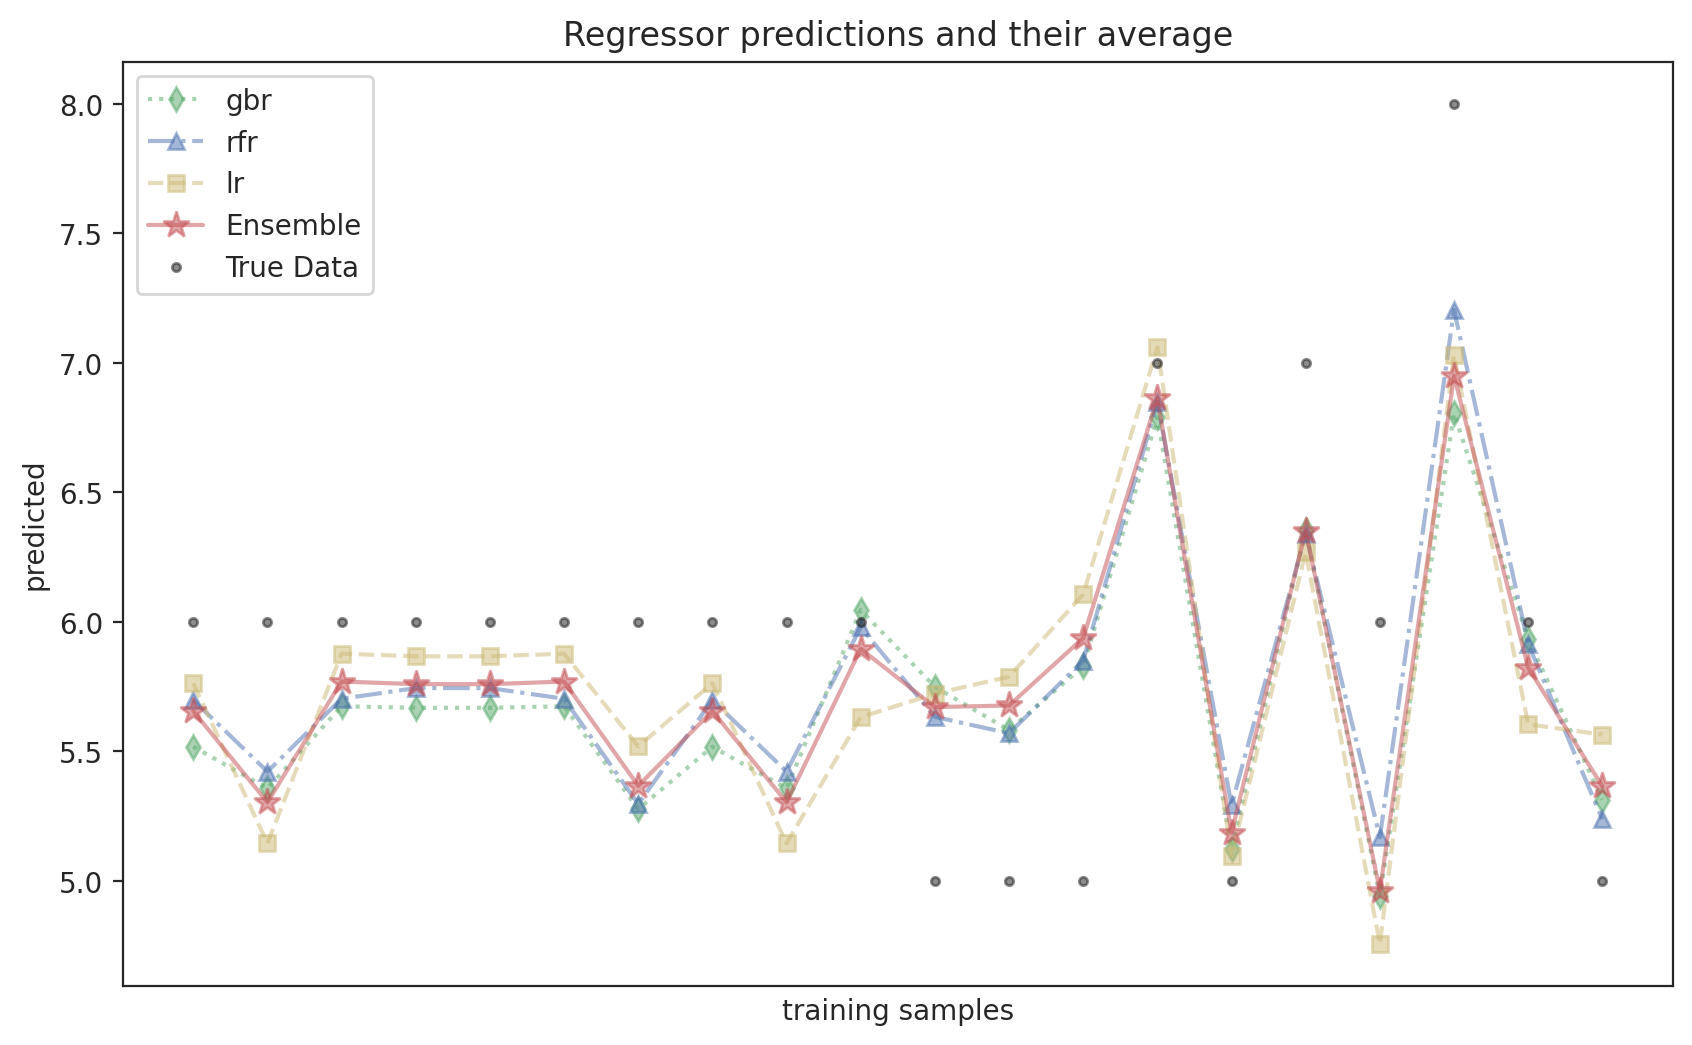

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(pred_gbr, "gd:", alpha=0.5, label="gbr")
ax.plot(pred_rfr, "b^-.", alpha=0.5, label="rfr")
ax.plot(pred_lr, "ys--", alpha=0.5, label="lr")
ax.plot(pred_ens, "r*-", alpha=0.5, ms=10, label="Ensemble")
ax.plot(yt, "ko", alpha=0.5, ms=3, label="True Data")

ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax.set_ylabel("predicted")
ax.set_xlabel("training samples")
ax.legend(loc="best")
ax.set_title("Regressor predictions and their average");